# Data Analysis for UK SDG 11.2.1 

In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_off

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import os
from math import cos
from modules import geo_df_from_csv, geo_df_from_geospatialfile, find_points_in_poly, draw_5km_buffer, get_and_save_geo_dataset, dl_csv_make_df

ModuleNotFoundError: No module named 'plotly'

In [3]:
#get current working directory 
cwd = os.getcwd()

# define data directory
data_dir = (os.path.join
            (cwd,
             'data'))

In [4]:
zip_link = "http://naptan.app.dft.gov.uk/DataRequest/Naptan.ashx?format=csv"
zip_name = "Napatan.zip"
zip_path = os.path.join(data_dir, zip_name)
csv_nm = 'Stops.csv'
csv_path = os.path.join(data_dir, csv_nm)

_ = dl_csv_make_df(csv_nm,
    csv_path,
    zip_name,
    zip_path,
    zip_link,
    data_dir)

csv already exists


In [5]:
# Create the geo dataframe with the stops data
cols =['NaptanCode', 'CommonName','Easting', 'Northing']

stops_geo_df = (geo_df_from_csv(path_to_csv=csv_path,
                            delim=',',
                            geom_x='Easting', # change to eastings and northings
                            geom_y='Northing',
                            cols=cols))

In [8]:
stops_geo_df.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [9]:
# # Getting the Lower Super Output Area for the UK into a dataframe
uk_LSOA_shp_file = "Lower_Layer_Super_Output_Areas__December_2011__Boundaries_EW_BGC.shp"
full_path = os.path.join(os.getcwd(), "data", "LSOA_shp", uk_LSOA_shp_file)
uk_LSOA_df = geo_df_from_geospatialfile(path_to_file=full_path)

In [10]:
uk_LSOA_df.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,Age_Indica,Shape__Are,Shape__Len,geometry
0,1,E01001019,Croydon 044B,Croydon 044B,0,1.515854e+06,8362.659636,"POLYGON ((530587.304 158905.439, 530600.686 15..."
1,2,E01000001,City of London 001A,City of London 001A,0,3.439074e+05,3682.439418,"POLYGON ((532105.104 182011.233, 532162.503 18..."
2,3,E01001020,Croydon 044C,Croydon 044C,0,9.354317e+05,7236.272525,"POLYGON ((530958.372 158290.140, 531018.013 15..."
3,4,E01001021,Croydon 044D,Croydon 044D,0,5.237812e+06,12160.534720,"POLYGON ((530583.015 158101.164, 530786.013 15..."
4,5,E01000002,City of London 001B,City of London 001B,0,5.834740e+05,3910.387238,"POLYGON ((532746.826 181786.894, 532671.701 18..."


In [11]:
# geo_df_from_geospatialfile(os.path.join
#                            (os.getcwd(),
#                             'data',
#                             'birmingham_geo_dataset.json'))

# # Manipulating the Birmingham df
# # splitting the "codes" column into "gss" and "unit_id"
# # setting "id" as the index
    
# birmingham_df = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T
# gss_code_cols = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T.codes.apply(pd.Series).drop("ons", axis=1) 
# birmingham_df = birmingham_df.join(gss_code_cols).drop(["codes", "all_names"], axis=1) 
# birmingham_df.set_index('id', inplace=True)

In [12]:
# birmingham_df.sample(10)

In [53]:
def get_polygons_of_loccode(geo_df, dissolveby='OA11CD', search=None):
    """
    Gets the polygon for a place based on it name, LSOA code or OA code
    
    Parameters:
    geo_df: (gpd.Datafame):
    loc_code = LSOA11CD, OA11CD or LSOA11NM
    search = search terms to find in the LSOA11NM column. Only needed if intending
        to dissolve on a name in the LSOA11NM column
    Returns: (gpd.DataFrame) agregated multipolygons, agregated on LSOA, OA code, or a search
        in the LSOA11NM column
    """
    if dissolveby in ['LSOA11CD', 'OA11CD']:
        polygon_df = geo_df.dissolve(by=dissolveby)
    else:
        filtered_df = geo_df[geo_df[f'{dissolveby}'].str.contains(search)]
        filtered_df.insert(0, 'place_name', search)
        polygon_df = filtered_df.dissolve(by='place_name')
    polygon_df = gpd.GeoDataFrame(polygon_df.pop('geometry'))
    return polygon_df

just_birmingham_poly = (get_polygons_of_loccode(geo_df=uk_LSOA_df, dissolveby='LSOA11NM', search="Birmingham"))

In [14]:
# Creating Birmingham polygon

# just_birmingham_geom = just_birmingham_LSOA.drop(["FID","LSOA11CD","LSOA11NMW","Age_Indica", "Shape__Are","Shape__Len","LSOA11NM"], axis=1)
# # just_birmingham_geom = just_birmingham_LSOA.pop('geometry')

# just_birmingham_geom['city'] = "birmingham"
# # just_birmingham_geom['new_column'] = 0
# just_birmingham_geom = just_birmingham_geom.dissolve(by='city')
# just_birmingham_geom

In [15]:
# Creating a Geo Dataframe of only stops in Birmingham
# import ipdb; ipdb.set_trace()
birmingham_stops_geo_df = (find_points_in_poly
                       (geo_df=stops_geo_df,
                        polygon_obj=just_birmingham_poly))

In [17]:
birmingham_stops_geo_df.sample(10)

,NaptanCode,CommonName,Easting,Northing,geometry
288538,nwmgmgjd,Hullbrook Rd,409088,280842,POINT (409088.000 280842.000)
292834,nwmdgapt,Cole Hall Lane,414327,287647,POINT (414327.000 287647.000)
287030,nwmdgjtd,The Fox and Goose,412566,288533,POINT (412566.000 288533.000)
294772,nwmawmga,Seven Acres Rd,403055,278547,POINT (403055.000 278547.000)
286713,nwmtwdmg,Alfred Rd,404240,289597,POINT (404240.000 289597.000)
287323,nwmgpmwt,Fairbourne Avenue,407294,294577,POINT (407294.000 294577.000)
284378,nwmatawt,Romsley Rd,400012,282184,POINT (400012.000 282184.000)
290934,nwmamdwd,Alderflat Place,409081,288154,POINT (409081.000 288154.000)
291002,nwmamjpd,Highfield Rd,410496,288733,POINT (410496.000 288733.000)
287329,nwmdatwt,The Radleys,415235,285258,POINT (415235.000 285258.000)


In [20]:
# Getting the west midlands population
Wmids_pop_df = pd.read_csv(os.path.join
                           (data_dir,
                            'population_estimates',
                            'westmids_pop_only.csv'))


/home/james/anaconda3/envs/SDG_11.2.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
# Get population weighted centroids into a dataframe
uk_pop_wtd_geometrycentr_df = (geo_df_from_geospatialfile
                       (os.path.join
                        (data_dir,
                         'pop_weighted_centroids')))

In [22]:
# Understanding was the OA11CD codes look like by taking a sample. 
uk_pop_wtd_centr_df.sample(10)

,OBJECTID,OA11CD,geometry
151947,151948,E00005806,POINT (532374.546 170505.379)
87065,87066,E00142361,POINT (451831.634 347629.051)
95577,95578,E00151086,POINT (384247.384 283759.755)
15524,15525,E00075664,POINT (364918.937 175719.305)
94502,94503,E00171430,POINT (401693.741 311692.683)
6274,6275,E00173597,POINT (526852.145 403138.439)
153811,153812,E00007270,POINT (532794.214 192714.885)
8161,8162,E00068328,POINT (436665.034 337654.421)
49326,49327,E00102505,POINT (280578.988 75188.951)
175111,175112,W00003614,POINT (230033.487 210522.150)


In [23]:
# Joining the population dataframe to the centroids dataframe
Wmids_pop_df =Wmids_pop_df.join(other=uk_pop_wtd_centr_df.set_index('OA11CD'), on='OA11CD', how='left')

In [24]:
# This is the dataframe with the population and the centroids
Wmids_pop_df.head(20)

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,83,84,85,86,87,88,89,90+,OBJECTID,geometry
0,E00045110,E01008881,293,1,3,2,2,4,7,4,...,0,4,4,2,2,3,0,2,131601,POINT (412863.495 285764.315)
1,E00045113,E01008881,357,5,4,8,5,0,6,6,...,0,1,0,1,0,1,0,1,131597,POINT (412464.046 285704.373)
2,E00045116,E01008881,411,10,4,5,9,10,6,13,...,0,0,1,2,3,1,0,2,131578,POINT (412565.558 285548.107)
3,E00045118,E01008881,395,3,7,2,4,7,2,6,...,2,2,1,3,5,2,4,1,131609,POINT (412840.944 285614.497)
4,E00045123,E01008881,277,4,3,7,4,4,7,5,...,3,1,0,0,2,2,0,5,132808,POINT (413001.776 285291.159)
5,E00045114,E01008882,324,4,0,5,6,2,9,5,...,3,0,3,0,0,0,1,1,131586,POINT (412008.144 285514.063)
6,E00045119,E01008882,422,8,8,11,8,9,8,10,...,0,2,1,0,3,0,3,0,131611,POINT (411830.355 285431.751)
7,E00045120,E01008882,368,9,8,5,7,5,4,6,...,1,1,1,0,4,0,0,0,132810,POINT (411631.842 285351.546)
8,E00045121,E01008882,339,9,5,12,3,7,4,6,...,1,2,0,0,2,0,0,1,132812,POINT (411959.871 285368.613)
9,E00045124,E01008882,376,5,9,5,13,9,4,6,...,2,0,1,1,0,1,0,0,132802,POINT (411485.761 285321.102)


In [23]:
Wmids_pop_df.shape

(17916, 96)

In [25]:
bham_clean = bham_LSOA_df[['LSOA11CD','LSOA11NM']]

NameError: name 'bham_LSOA_df' is not defined

In [24]:
bham_LSOA_df = uk_LSOA_df[uk_LSOA_df.LSOA11NM.str.contains("Birmingham")]

In [26]:
# merge the two dataframes limiting to just Birmingham

bham_pop_df = Wmids_pop_df.merge(bham_clean, how='right', left_on='LSOA11CD', right_on='LSOA11CD')



In [27]:
bham_pop_df.head()

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,84,85,86,87,88,89,90+,OBJECTID,geometry,LSOA11NM
0,E00046134,E01009100,320,1,4,4,1,3,5,2,...,1,2,1,1,2,1,5,133250,POINT (-1.81546 52.52001),Birmingham 025D
1,E00046136,E01009100,358,4,4,2,6,7,8,5,...,3,0,4,0,1,2,4,133246,POINT (-1.81418 52.51789),Birmingham 025D
2,E00046145,E01009100,201,1,1,2,3,1,4,1,...,1,0,1,0,0,0,2,131136,POINT (-1.81578 52.52586),Birmingham 025D
3,E00046184,E01009100,335,7,1,3,5,6,3,2,...,2,4,2,3,3,2,14,132183,POINT (-1.81406 52.52726),Birmingham 025D
4,E00175609,E01009100,244,5,3,4,1,6,5,6,...,0,0,1,1,0,0,2,133854,POINT (-1.81467 52.52434),Birmingham 025D


In [32]:
birmingham_stops_geo_df

,NaptanCode,CommonName,Easting,Northing,geometry
133809,wocdjdam,Groveley Lane- Chestnut Drive,400503,275966,POINT (400503.000 275966.000)
133932,wocdgwmt,Grovely Corner-,403083,277083,POINT (403083.000 277083.000)
135404,wocdtmdw,Edenhurst Road,401532,276681,POINT (401532.000 276681.000)
136947,wocgmpwt,Longbridge- Groveley Lane- Coombs Lane,401662,276707,POINT (401662.000 276707.000)
136948,wocgmtad,Longbridge- Groveley Lane- Coombs Lane,401689,276794,POINT (401689.000 276794.000)
...,...,...,...,...,...
438117,NaN,Soho Benson Road (Midland Metro Stop),404771,288778,POINT (404771.000 288778.000)
438118,nwmwpgam,Soho Benson Road (Midland Metro Stop),404771,288776,POINT (404771.000 288776.000)
438119,nwmwpgap,Soho Benson Road (Midland Metro Stop),404771,288777,POINT (404771.000 288777.000)
438120,NaN,St Paul's (Midland Metro Stop),406621,287642,POINT (406621.000 287642.000)


In [46]:
# make buffer around stops

def buffer_points(geo_df, distance_km=0.5):
    """
    Provide a Geo Dataframe with points you want buffering.
    Draws a 5km (radius) buffer around the points.
    Puts the results into a new column called "buffered"
    As 'epsg:27700' projections units of km, 500m is 0.5km.
    """
    geo_df['geometry'] = geo_df.geometry.buffer(distance_km)
    return geo_df
    


birmingham_buffd_stops = buffer_points(birmingham_stops_geo_df)

In [56]:
# TODO: try to join all the birmingham buffered stops together
# to get the service area, then plot them
#

birmingham_buffd_stops['place']='Birmingham'

birmingham_buffd_stops = birmingham_buffd_stops.dissolve(by='place')

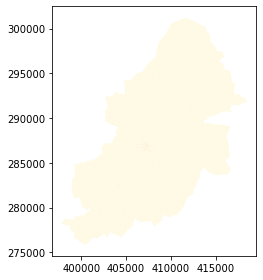

In [57]:
# Get all the buffered stops in Birmingham on to a map of Birmingham
fig, ax = plt.subplots()
_ = just_birmingham_poly.plot(ax=ax, color='gold', markersize=2, alpha=0.1)
_ = birmingham_buffd_stops.plot(ax=ax, color='red', markersize=2, alpha=0.5)

plt.tight_layout()